# Reshaping data for model
### In this file, we will take the data that has been gathered and harmonized and we will fit it, create scenarios, and save it as a structured array for the model. Since we would like to keep the flexibility with excel, we will also save it in an ODYM compatible format and create a file that can do the reverse: if teh excel file is eddited, so is the array. This will be a separate script

In [1]:
# Load a local copy of the current ODYM branch:
import sys
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from seaborn.palettes import color_palette
import xlrd
import pylab
from copy import deepcopy
import logging as log
import xlwt
import tqdm
import math
from scipy.stats import norm
from tqdm import tqdm
import matplotlib
from logistic import logistic as logistic
mpl_logger = log.getLogger("matplotlib")
mpl_logger.setLevel(log.WARNING)  
# For Ipython Notebook only
### Preamble
# Going to parent path
os.getcwd()
os.chdir("..")
os.chdir("..")

In [2]:

xlrd.xlsx.Element_has_iter = True

# add ODYM module directory to system path, relative
MainPath = os.path.join(os.getcwd(), 'odym', 'modules')
sys.path.insert(0, MainPath)

# add ODYM module directory to system path, absolute
sys.path.insert(0, os.path.join(os.getcwd(), 'odym', 'modules'))

# Specify path to dynamic stock model and to datafile, relative
DataPath = os.path.join( 'docs', 'files')

# Specify path to dynamic stock model and to datafile, absolute
DataPath = os.path.join(os.getcwd(), 'docs', 'Files')

import ODYM_Classes as msc # import the ODYM class file
import ODYM_Functions as msf # import the ODYM function file
import dynamic_stock_model as dsm # import the dynamic stock model library

# Initialize loggin routine
log_verbosity = eval("log.DEBUG")
log_filename = 'LogFileTest.md'
[Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(),
                                                     log_verbosity, log_verbosity)
Mylog.info('### 1. - Initialize.')

#Read main script parameters
#Load project-specific config file
ProjectSpecs_ConFile = 'ODYM_Config_Vehicle_System.xlsx'
Model_Configfile     = xlrd.open_workbook(os.path.join(DataPath, ProjectSpecs_ConFile))
ScriptConfig         = {'Model Setting': Model_Configfile.sheet_by_name('Config').cell_value(3,3)} # Dictionary with config parameters
Model_Configsheet    = Model_Configfile.sheet_by_name('Setting_' + ScriptConfig['Model Setting'])

Name_Scenario        = Model_Configsheet.cell_value(3,3)
print(Name_Scenario)

#Read control and selection parameters into dictionary
ScriptConfig         = msf.ParseModelControl(Model_Configsheet,ScriptConfig)

Mylog.info('Read and parse config table, including the model index table, from model config sheet.')
IT_Aspects,IT_Description,IT_Dimension,IT_Classification,IT_Selector,IT_IndexLetter,\
PL_Names,PL_Description,PL_Version,PL_IndexStructure,PL_IndexMatch,PL_IndexLayer,\
PrL_Number,PrL_Name,PrL_Comment,PrL_Type,ScriptConfig = msf.ParseConfigFile(Model_Configsheet,ScriptConfig,Mylog)    

class_filename       = 'ODYM_Classifications_Master_Vehicle_System.xlsx'
Classfile            = xlrd.open_workbook(os.path.join(DataPath,class_filename))
Classsheet           = Classfile.sheet_by_name('MAIN_Table')
MasterClassification = msf.ParseClassificationFile_Main(Classsheet,Mylog)


Mylog.info('Define model classifications and select items for model classifications according to information provided by config file.')
ModelClassification  = {} # Dict of model classifications
for m in range(0,len(IT_Aspects)):
    ModelClassification[IT_Aspects[m]] = deepcopy(MasterClassification[IT_Classification[m]])
    EvalString = msf.EvalItemSelectString(IT_Selector[m],len(ModelClassification[IT_Aspects[m]].Items))
    if EvalString.find(':') > -1: # range of items is taken
        RangeStart = int(EvalString[0:EvalString.find(':')])
        RangeStop  = int(EvalString[EvalString.find(':')+1::])
        ModelClassification[IT_Aspects[m]].Items = ModelClassification[IT_Aspects[m]].Items[RangeStart:RangeStop]           
    elif EvalString.find('[') > -1: # selected items are taken
        ModelClassification[IT_Aspects[m]].Items = [ModelClassification[IT_Aspects[m]].Items[i] for i in eval(EvalString)]
    elif EvalString == 'all':
        None
    else:
        Mylog.error('Item select error for aspect ' + IT_Aspects[m] + ' were found in datafile.')
        break

# Define model index table and parameter dictionary
Mylog.info('### 2.2 - Define model index table and parameter dictionary')
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End   = int(max(ModelClassification['Time'].Items))
Model_Duration   = Model_Time_End - Model_Time_Start + 1

Mylog.info('Define index table dataframe.')
IndexTable = pd.DataFrame({'Aspect'        : IT_Aspects,  # 'Time' and 'Element' must be present!
                           'Description'   : IT_Description,
                           'Dimension'     : IT_Dimension,
                           'Classification': [ModelClassification[Aspect] for Aspect in IT_Aspects],
                           'IndexLetter'   : IT_IndexLetter})  # Unique one letter (upper or lower case) indices to be used later for calculations.

# Default indexing of IndexTable, other indices are produced on the fly
IndexTable.set_index('Aspect', inplace=True)

# Add indexSize to IndexTable:
IndexTable['IndexSize'] = pd.Series([len(IndexTable.Classification[i].Items) for i in range(0, len(IndexTable.IndexLetter))],
                                    index=IndexTable.index)

# list of the classifications used for each indexletter
IndexTable_ClassificationNames = [IndexTable.Classification[i].Name for i in range(0, len(IndexTable.IndexLetter))]


# Define dimension sizes
Nt = len(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items)
Nc = len(IndexTable.Classification[IndexTable.index.get_loc('Age-cohort')].Items)
Ng = len(IndexTable.Classification[IndexTable.index.get_loc('Drive_train')].Items)
Ne = len(IndexTable.Classification[IndexTable.index.get_loc('Element')].Items)
Nb = len(IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items)
Ns = len(IndexTable.Classification[IndexTable.index.get_loc('Size')].Items)
Nh = len(IndexTable.Classification[IndexTable.index.get_loc('Recycling_Process')].Items)
NS = len(IndexTable.Classification[IndexTable.index.get_loc('EV_penetration_scenario')].Items)
Na = len(IndexTable.Classification[IndexTable.index.get_loc('Chemistry_Scenarios')].Items)
Nz = len(IndexTable.Classification[IndexTable.index.get_loc('Stock_Scenarios')].Items)
NR = len(IndexTable.Classification[IndexTable.index.get_loc('Reuse_Scenarios')].Items)
NE = len(IndexTable.Classification[IndexTable.index.get_loc('Energy_Storage_Scenarios')].Items)
Nv = len(IndexTable.Classification[IndexTable.index.get_loc('V2G_Scenarios')].Items)

INFO (3218493841.py <<module>>): ### 1. - Initialize.
INFO (3218493841.py <<module>>): Read and parse config table, including the model index table, from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read parameter list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read process list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model run control from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model output control from model config sheet.
INFO (ODYM_Functions.py <ParseClassificationFile_Main>): End of file or formatting error while reading the classification file in column 16. Check if all classifications are present. If yes, you are good to go!
INFO (3218493841.py <<module>>): Define model classifications and select items for model classifications according to information provided by config file.
INFO (3218493841.py <<module>>): ### 2.2 - Define model index table and parameter dictionary
INFO

Vehicle stock model for European fleet


In [3]:
# Defining path to raw data
data_path = os.path.join(os.getcwd(), 'data', 'raw_data')
# Importing data
data = pd.read_excel(data_path+'/batteryChemistry_2005_2050.xlsx', sheet_name='Sheet1')
data.tail()

,Battery_Scenarios,Year,LFP,NCA,NCM111,NCM523,NCM622,NCM622-Graphite (Si),NCM811-Graphite (Si),NCM955-Graphite (Si),Li-Sulphur,Li-Air,LMO/NMC,Source,Sum
271,All_LFP,2046,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
272,All_LFP,2047,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
273,All_LFP,2048,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
274,All_LFP,2049,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
275,All_LFP,2050,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [4]:
# drop irrelevant rows
data.drop(['Source', 'Sum'], axis=1, inplace=True)

### Preparing battery chemistry file per segment

In [5]:
chem = data
chem.keys()

Index(['Battery_Scenarios', 'Year ', 'LFP', 'NCA', 'NCM111', 'NCM523',
       'NCM622', 'NCM622-Graphite (Si)', 'NCM811-Graphite (Si)',
       'NCM955-Graphite (Si)', 'Li-Sulphur', 'Li-Air', 'LMO/NMC'],
      dtype='object')

In [6]:
chem.head()

,Battery_Scenarios,Year,LFP,NCA,NCM111,NCM523,NCM622,NCM622-Graphite (Si),NCM811-Graphite (Si),NCM955-Graphite (Si),Li-Sulphur,Li-Air,LMO/NMC
0,NCX,2005,0.239864,0.191891,0.568245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NCX,2006,0.239864,0.191891,0.568245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NCX,2007,0.239864,0.191891,0.568245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NCX,2008,0.239864,0.191891,0.568245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NCX,2009,0.239864,0.191891,0.568245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
chem.set_index(['Battery_Scenarios', 'Year '])

LFP       NCA    NCM111  NCM523  NCM622  \
Battery_Scenarios Year                                                  
NCX               2005   0.239864  0.191891  0.568245     0.0     0.0   
                  2006   0.239864  0.191891  0.568245     0.0     0.0   
                  2007   0.239864  0.191891  0.568245     0.0     0.0   
                  2008   0.239864  0.191891  0.568245     0.0     0.0   
                  2009   0.239864  0.191891  0.568245     0.0     0.0   
...                           ...       ...       ...     ...     ...   
All_LFP           2046   1.000000  0.000000  0.000000     0.0     0.0   
                  2047   1.000000  0.000000  0.000000     0.0     0.0   
                  2048   1.000000  0.000000  0.000000     0.0     0.0   
                  2049   1.000000  0.000000  0.000000     0.0     0.0   
                  2050   1.000000  0.000000  0.000000     0.0     0.0   

                         NCM622-Graphite (Si)  NCM811-Graphite (Si)  \
Battery_Scenarios Year                                                
NCX               2005                    0.0                   0.0   
                  2006                    0.0                   0.0   
                  2007                    0.0                   0.0   
                  2008                    0.0                   0.0   
                  2009                    0.0                   0.0   
...                                       ...                   ...   
All_LFP           2046                    0.0                   0.0   
                  2047                    0.0                   0.0   
                  2048                    0.0                   0.0   
                  2049                    0.0                   0.0   
                  2050                    0.0                   0.0   

                         NCM955-Graphite (Si)  Li-Sulphur  Li-Air  LMO/NMC  
Battery_Scenarios Year                                                      
NCX               2005                    0.0         0.0     0.0      0.0  
                  2006                    0.0         0.0     0.0      0.0  
                  2007                    0.0         0.0     0.0      0.0  
                  2008                    0.0         0.0     0.0      0.0  
                  2009                    0.0         0.0     0.0      0.0  
...                                       ...         ...     ...      ...  
All_LFP           2046                    0.0         0.0     0.0      0.0  
                  2047                    0.0         0.0     0.0      0.0  
                  2048                    0.0         0.0     0.0      0.0  
                  2049                    0.0         0.0     0.0      0.0  
                  2050                    0.0         0.0     0.0      0.0  

[276 rows x 11 columns]

In [8]:
chem2 = chem.melt(['Battery_Scenarios', 'Year '])

In [9]:
IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items[9] == 'Li-Air'

False

In [10]:
chem2.head()

,Battery_Scenarios,Year,variable,value
0,NCX,2005,LFP,0.239864
1,NCX,2006,LFP,0.239864
2,NCX,2007,LFP,0.239864
3,NCX,2008,LFP,0.239864
4,NCX,2009,LFP,0.239864


In [11]:
chem2.head()

,Battery_Scenarios,Year,variable,value
0,NCX,2005,LFP,0.239864
1,NCX,2006,LFP,0.239864
2,NCX,2007,LFP,0.239864
3,NCX,2008,LFP,0.239864
4,NCX,2009,LFP,0.239864


In [12]:
IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items

['LMO/NMC',
 'NCA',
 'LFP',
 'NCM111',
 'NCM217',
 'NCM523',
 'NCM622',
 'NCM622-Graphite (Si)',
 'NCM712-Graphite (Si)',
 'NCM811-Graphite (Si)',
 'NCM955-Graphite (Si)',
 'Li-Air',
 'Li-Sulphur',
 'LNO',
 'NCMA',
 'NiMH',
 'LTO']

In [13]:
chem2.variable.unique()

array(['LFP', 'NCA', 'NCM111', 'NCM523', 'NCM622', 'NCM622-Graphite (Si)',
       'NCM811-Graphite (Si)', 'NCM955-Graphite (Si)', 'Li-Sulphur',
       'Li-Air', 'LMO/NMC'], dtype=object)

In [14]:
# Assming PHEVs have the same battery chemistry scenarios as BEVs
ChemArray = np.zeros((Na,Ng,Nb,Nt))
for s in range(10):
    for m in range(0, len(chem2.Battery_Scenarios.values)):
        try:
            ScenarioPosition = IndexTable.Classification[IndexTable.index.get_loc('Chemistry_Scenarios')].Items.index(chem2.Battery_Scenarios.values[m])
            ChemistryPosition= IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items.index(chem2.variable.values[m])
            Timeposition = IndexTable.Classification[IndexTable.index.get_loc('Time')].Items.index(chem2['Year '].values[m])
            ChemArray[ScenarioPosition, 1, ChemistryPosition, Timeposition] = chem2.value.values[m]
            ChemArray[ScenarioPosition, 2, ChemistryPosition, Timeposition] = chem2.value.values[m]
        except ValueError:
            pass

In [15]:
results_path = os.path.join(os.getcwd(), 'data', 'scenario_data')
np.save(results_path+'/battery_chemistries', ChemArray)


In [16]:
IndexTable.Classification[IndexTable.index.get_loc('Chemistry_Scenarios')].Items

['NCX', 'LFP', 'Next_gen', 'BNEF', 'All_LFP', 'Next_gen_LFP']

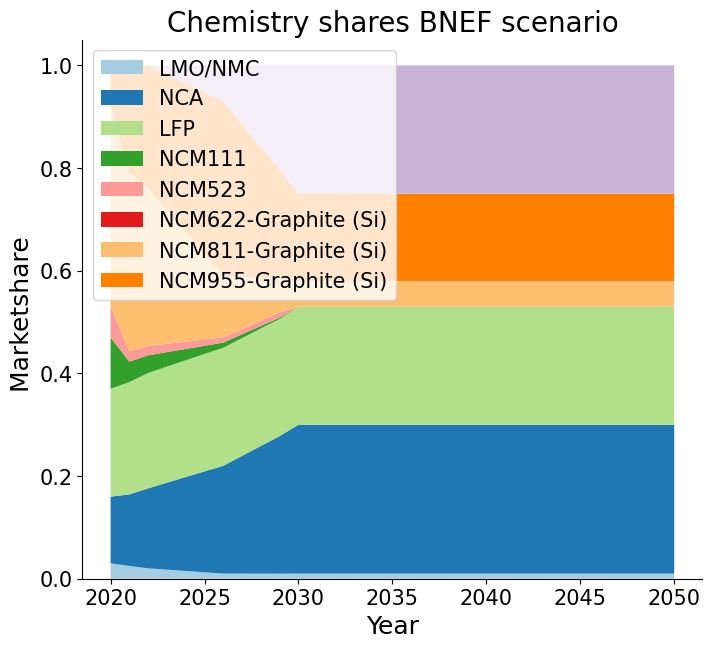

In [20]:
from cycler import cycler
import seaborn as sns
r=3
custom_cycler = cycler(color=sns.color_palette('Paired', 20)) #'Set2', 'Paired', 'YlGnBu'
fig, ax = plt.subplots(figsize=(8,7)) ### The legend is wrong
s = 3
t = 70
ax.set_prop_cycle(custom_cycler)
ax.stackplot(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items[t:], 
        [ChemArray[s,1,i,t:] for i in np.einsum('bt->b', ChemArray[s,1,:t:]).nonzero()[0].tolist()])
ax.set_ylabel('Marketshare ',fontsize =18)
right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines["top"]
top.set_visible(False)
#plt.grid()
ax.legend([IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items[i] for i in np.einsum('bt->b', ChemArray[s,1,:,70:]).nonzero()[0].tolist()], loc='upper left',prop={'size':15})
ax.set_title('Chemistry shares {} scenario'.format(IndexTable.Classification[IndexTable.index.get_loc('Chemistry_Scenarios')].Items[s]), fontsize=20)
ax.set_xlabel('Year',fontsize =18)
ax.tick_params(axis='both', which='major', labelsize=15)